# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    GridSearchCV,
)

from sklearn.metrics import (
    f1_score,
    make_scorer,
    confusion_matrix,
    classification_report,
)

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Data

The dataset 2 is the one kept for the next steps (both datasets are really similar so choosing one does not really impact the rest of the study). The following columns are dropped from the dataset 2 : 
- "Cycle(R/I)" : the information given by the categories of this column is unclear 
- "Unnamed: 42", "Sl. No", "Patient File No." : does not bring any additionnal info
- BMI : Information vehiculated more accurately by the height and weight measurements
- Waist:Hip Ratio : Information vehiculated more accurately by the waist and hip measurements
- FSH/LH : Information vehiculated more accurately by the FSH and LH measurements

In [2]:
data = pd.read_csv("./data/dataset_2.csv")
data = data.drop(
    columns=[
        "BMI",
        "Cycle(R/I)",
        "FSH/LH",
        "Unnamed: 42",
        "Sl. No",
        "Patient File No.",
        "Waist:Hip Ratio",
    ]
)
data = data.apply(pd.to_numeric, errors="coerce")


In [3]:
# Columns with missing values are :
columns_with_missing_values = data.columns[data.isna().any()].tolist()
columns_with_missing_values


['Marraige Status (Yrs)', 'AMH(ng/mL)', 'Fast food (Y/N)']

In [4]:
data = data.dropna(subset=["Fast food (Y/N)", "Marraige Status (Yrs)", "AMH(ng/mL)"])


In [5]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 538 entries, 0 to 540
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PCOS (Y/N)             538 non-null    int64  
 1    Age (yrs)             538 non-null    int64  
 2   Weight (Kg)            538 non-null    float64
 3   Height(Cm)             538 non-null    float64
 4   Blood Group            538 non-null    int64  
 5   Pulse rate(bpm)        538 non-null    int64  
 6   RR (breaths/min)       538 non-null    int64  
 7   Hb(g/dl)               538 non-null    float64
 8   Cycle length(days)     538 non-null    int64  
 9   Marraige Status (Yrs)  538 non-null    float64
 10  Pregnant(Y/N)          538 non-null    int64  
 11  No. of aborptions      538 non-null    int64  
 12  FSH(mIU/mL)            538 non-null    float64
 13  LH(mIU/mL)             538 non-null    float64
 14  Hip(inch)              538 non-null    int64  
 15  Waist(

In [6]:
data.head()


,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle length(days),Marraige Status (Yrs),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,0,28,44.6,152.0,15,78,22,10.48,5,7.0,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,0,36,65.0,161.5,15,74,20,11.70,5,11.0,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7
2,1,33,68.8,165.0,11,72,18,11.80,5,10.0,...,1,1.0,0,120,80,13,15,18.0,20.0,10.0
3,0,37,65.0,148.0,13,72,20,12.00,5,4.0,...,0,0.0,0,120,70,2,2,15.0,14.0,7.5
4,0,25,52.0,161.0,11,72,18,10.00,5,1.0,...,0,0.0,0,120,80,3,4,16.0,14.0,7.0


In [7]:
data.columns


Index(['PCOS (Y/N)', ' Age (yrs)', 'Weight (Kg)', 'Height(Cm) ', 'Blood Group',
       'Pulse rate(bpm) ', 'RR (breaths/min)', 'Hb(g/dl)',
       'Cycle length(days)', 'Marraige Status (Yrs)', 'Pregnant(Y/N)',
       'No. of aborptions', 'FSH(mIU/mL)', 'LH(mIU/mL)', 'Hip(inch)',
       'Waist(inch)', 'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)',
       'Vit D3 (ng/mL)', 'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)',
       'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)',
       'Pimples(Y/N)', 'Fast food (Y/N)', 'Reg.Exercise(Y/N)',
       'BP _Systolic (mmHg)', 'BP _Diastolic (mmHg)', 'Follicle No. (L)',
       'Follicle No. (R)', 'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)',
       'Endometrium (mm)'],
      dtype='object')

In [8]:
X = data.iloc[:, 1:]
y = data["PCOS (Y/N)"]

# Binary variables
binary_variables = [
    "Pregnant(Y/N)",
    "Weight gain(Y/N)",
    "hair growth(Y/N)",
    "Skin darkening (Y/N)",
    "Hair loss(Y/N)",
    "Pimples(Y/N)",
    "Fast food (Y/N)",
    "Reg.Exercise(Y/N)",
]
continuous_variables = [
    col for col in X.columns if col not in binary_variables and col != "Blood Group"
]


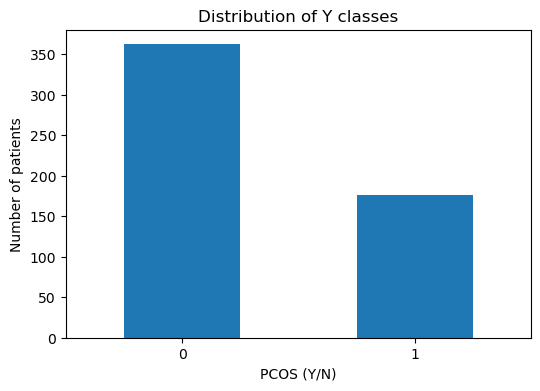

0    362
1    176
Name: PCOS (Y/N), dtype: int64


In [9]:
y_distribution = data["PCOS (Y/N)"].value_counts()
plt.figure(figsize=(6, 4))
y_distribution.plot(kind="bar")
plt.title("Distribution of Y classes")
plt.xlabel("PCOS (Y/N)")
plt.ylabel("Number of patients")
plt.xticks(rotation=0)
plt.show()

# Afficher les proportions des classes
print(y_distribution)


# Modelisation steps

## The preprocessor

In [10]:
# the transformers
binary_transformer = OneHotEncoder()
continuous_transformer = StandardScaler()

# the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        # ("binary", binary_transformer, binary_variables),
        ("continuous", continuous_transformer, continuous_variables),
    ],
    remainder="passthrough",  # keep the non treated columns (especially blood groups)
)


## The classifier

In [11]:
# Classifier
clf = LogisticRegression(
    class_weight="balanced",
    multi_class="auto",
    max_iter=10000,
    random_state=0,
    solver="liblinear",
    penalty="l1",
)


## The pipeline

In [12]:
pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", clf)])


## Train test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=0
)


In [14]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('continuous',
                                                  StandardScaler(),
                                                  [' Age (yrs)', 'Weight (Kg)',
                                                   'Height(Cm) ',
                                                   'Pulse rate(bpm) ',
                                                   'RR (breaths/min)',
                                                   'Hb(g/dl)',
                                                   'Cycle length(days)',
                                                   'Marraige Status (Yrs)',
                                                   'No. of aborptions',
                                                   'FSH(mIU/mL)', 'LH(mIU/mL)',
                                                   'Hip(inch)', 'Waist(inch)',
                                            

## Check metrics

1. On train data

In [15]:
# Classification report
y_train_pred = pipeline.predict(X_train)
print(
    classification_report(y_train, y_train_pred, target_names=["No PCOS", "Yes PCOS"])
)


              precision    recall  f1-score   support

     No PCOS       0.95      0.91      0.93       253
    Yes PCOS       0.83      0.91      0.87       123

    accuracy                           0.91       376
   macro avg       0.89      0.91      0.90       376
weighted avg       0.91      0.91      0.91       376



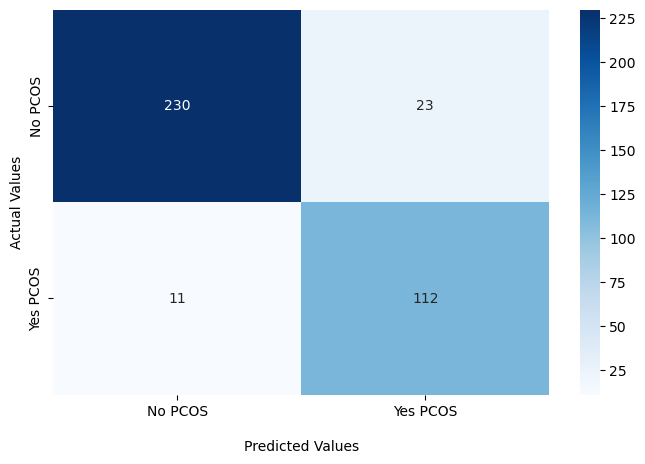

In [16]:
# Confusion matrix
cf_matrix = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(8, 5))
ax = sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt=".0f")
ax.set_xlabel("\nPredicted Values")
ax.set_ylabel("Actual Values")
ax.xaxis.set_ticklabels(["No PCOS", "Yes PCOS"])
ax.yaxis.set_ticklabels(["No PCOS", "Yes PCOS"])

plt.show()


2. On test data

In [17]:
# classification_report
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["No PCOS", "Yes PCOS"]))


              precision    recall  f1-score   support

     No PCOS       0.94      0.83      0.88       109
    Yes PCOS       0.71      0.89      0.79        53

    accuracy                           0.85       162
   macro avg       0.82      0.86      0.83       162
weighted avg       0.86      0.85      0.85       162



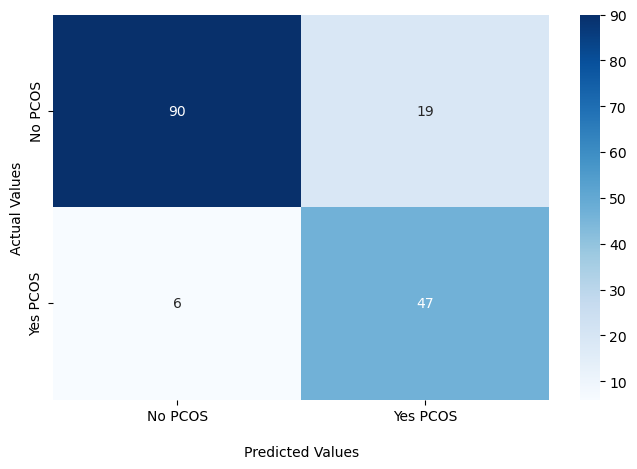

In [18]:
# Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 5))
ax = sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt=".0f")
ax.set_xlabel("\nPredicted Values")
ax.set_ylabel("Actual Values")
ax.xaxis.set_ticklabels(["No PCOS", "Yes PCOS"])
ax.yaxis.set_ticklabels(["No PCOS", "Yes PCOS"])

plt.show()


## Features importance

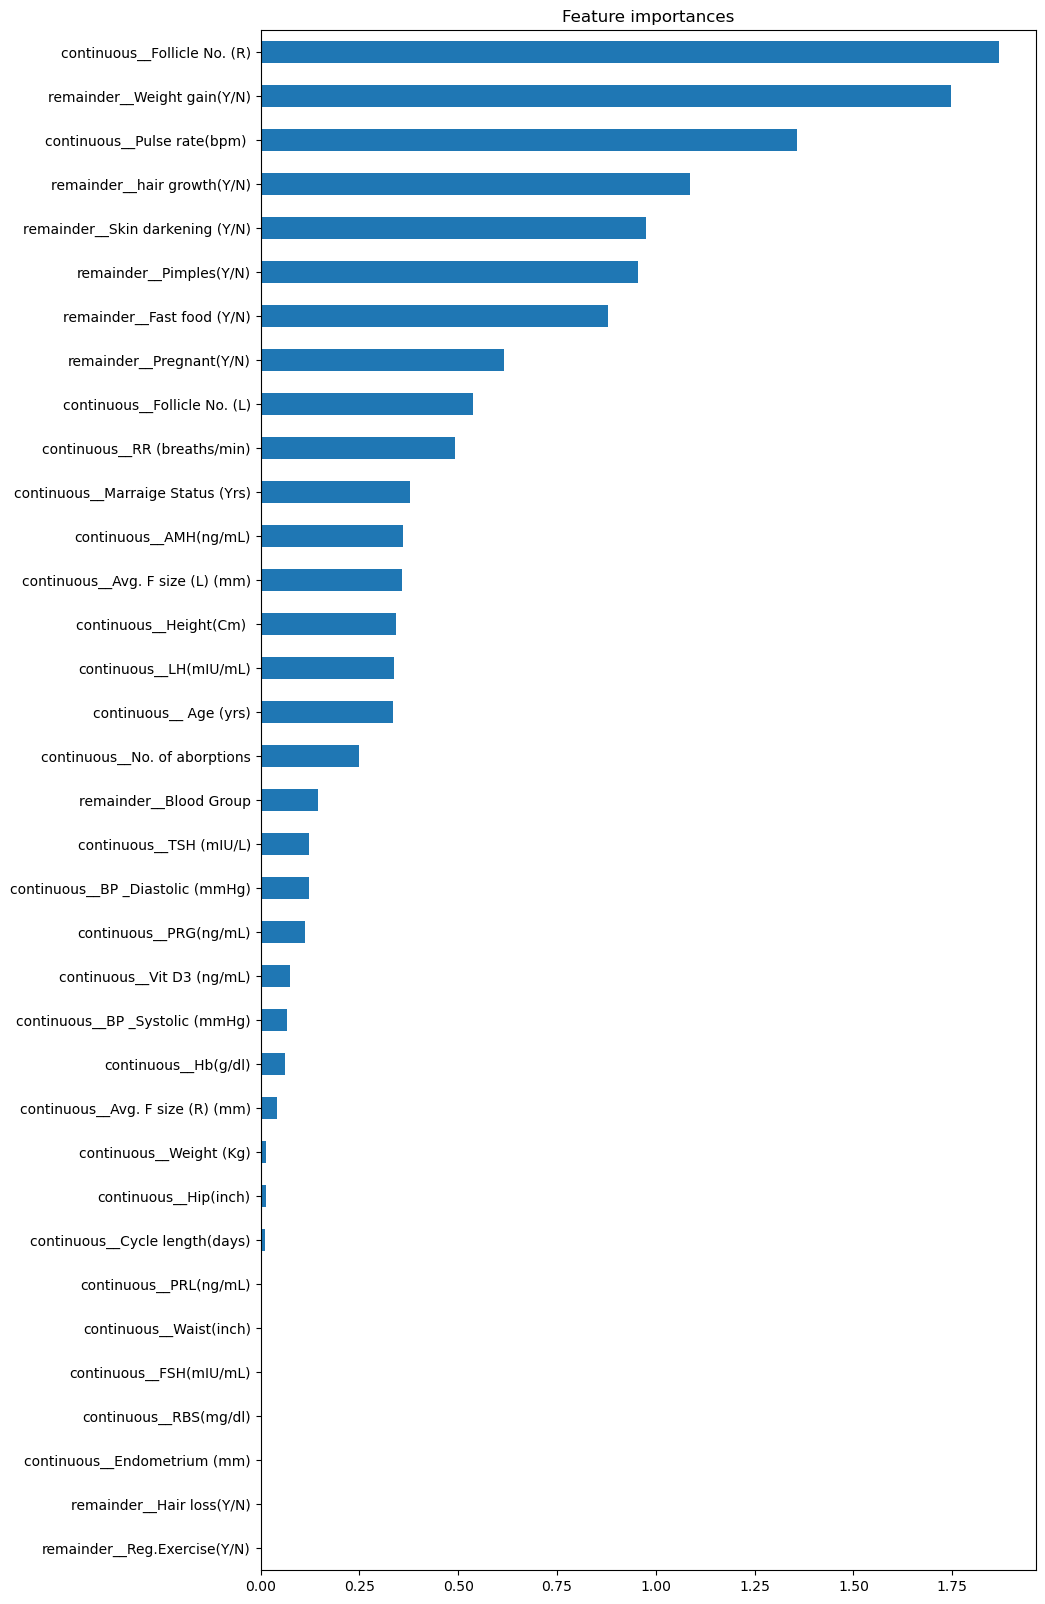

In [19]:
feature_names = pipeline[:-1].get_feature_names_out(pipeline.feature_names_in_)
importances = pd.Series(
    pipeline.named_steps["classifier"].coef_[0].reshape(len(feature_names)),
    index=feature_names,
    name="feature_importance",
).abs()
fig, ax = plt.subplots(figsize=(10, 20))
importances.sort_values().plot.barh()
plt.title("Feature importances")
plt.show()


# Conclusion

The scores look good for a basic model. But the next step is to optimize the hyperparameters so the predictions match the actual values better. 